In [ ]:
import numpy as np
import pandas as pd
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from tabulate import tabulate
from lib import features
from collections import defaultdict

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train.info()

In [ ]:
train.columns

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

train.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
correlations=train.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.iloc[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]

unique_important_corrs

In [ ]:
corrMatrix=train[["SalePrice","OverallQual","GrLivArea","GarageCars",
                  "GarageArea","GarageYrBlt","TotalBsmtSF","1stFlrSF","FullBath",
                  "TotRmsAbvGrd","YearBuilt","YearRemodAdd"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features');

In [ ]:
matrix = train.corr()
matrix["SalePrice"].sort_values(ascending = False)

In [ ]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

y = np.log(data.SalePrice)
X = data.drop(["SalePrice", "Id"], axis=1)
names = X.columns

rf = RandomForestRegressor()
scores = defaultdict(list)

for train_idx, test_idx in sklearn.model_selection.ShuffleSplit(test_size=.3, n_splits=100).split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
    r = rf.fit(X_train, Y_train)
    acc = r2_score(Y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t.iloc[:, i].values)
        shuff_acc = r2_score(Y_test, rf.predict(X_t))
        scores[names[i]].append((acc - shuff_acc) / acc)
print("Mean decrease accuracy:")
for score, feature in sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True)[:5]:
    print(score, feature)

In [ ]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
X = data.drop(['SalePrice', 'Id'], axis=1)
y = np.log(train.SalePrice)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

lr = linear_model.LinearRegression()

rfe = RFE(lr, 5)
fit = rfe.fit(X_train, y_train)
print("Features: {features}".format(features=X.columns))
print("Num Features: {number_features}".format(number_features=fit.n_features_))
print("Selected Features: {support}".format(support=fit.support_))
print("Feature Ranking: {ranking}".format(ranking=fit.ranking_))

selected_columns = [column for column, selected in zip(X.columns, fit.support_) if selected]
print("Selected columns: {selected}".format(selected = selected_columns))

In [ ]:
train[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF']].head()

In [ ]:
train["GarageArea"].corr(train["GarageCars"])
# No point having both of these given how similar they are

In [ ]:
train[["GarageArea", "GarageCars"]].head()

In [ ]:
combined_sf = train.copy()
combined_sf["TotalSF"] = combined_sf["1stFlrSF"] + combined_sf["2ndFlrSF"]
print(combined_sf[["TotalSF", "1stFlrSF", "2ndFlrSF"]].head())
print("Correlation", combined_sf["TotalSF"].corr(combined_sf["SalePrice"]))
print(combined_sf.corr()["TotalSF"].sort_values(ascending = False))
# GrLiveArea and TotalSF are almost identical - only need to keep one of them

In [ ]:
combined_bath = train.copy()
train["FullBath"].corr(train["HalfBath"])
combined_bath["TotalBath"] = combined_bath["FullBath"] + (0.5 * combined_bath["HalfBath"])
print(combined_bath[["TotalBath", "FullBath", "HalfBath"]].head())
print("Correlation", combined_bath["TotalBath"].corr(combined_bath["SalePrice"]))
print(combined_bath.corr()["TotalBath"].sort_values(ascending = False))
# has quite a strong correlation with GrLivArea so perhaps we don't need both of them

In [ ]:
def create_linear_model(data):
    y = np.log(train.SalePrice)
    X = data.drop(['SalePrice', 'Id'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)
    lr = linear_model.LinearRegression()
    model = lr.fit(X_train, y_train)
    return model, X_test, y_test

def test_model(model, X_test, y_test):
    return model.score(X_test, y_test), mean_squared_error(y_test, model.predict(X_test))

In [ ]:
def clean_nulls(data):
    new_data = data.copy()

    new_data["MasVnrType"] = new_data["MasVnrType"].fillna('None')
    new_data["MasVnrArea"] = new_data["MasVnrArea"].fillna(0.0)
    new_data["Alley"] = new_data["Alley"].fillna('None')
    basement_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2']
    for col in basement_cols:
        if 'FinSF' not in col:
            new_data[col] = new_data[col].fillna('None')
    new_data["FireplaceQu"] = new_data["FireplaceQu"].fillna('None')
    garage_cols = ['GarageType', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea']
    for col in garage_cols:
        if new_data[col].dtype == np.object:
            new_data[col] = new_data[col].fillna('None')
        else:
            new_data[col] = new_data[col].fillna(0)
    new_data.Fence = new_data.Fence.fillna("None")
    new_data.MiscFeature = new_data.MiscFeature.fillna("None")

    missing_lot_frontage = new_data['LotFrontage'].isnull()
    new_data['SqrtLotArea'] = np.sqrt(new_data['LotArea'])
    # new_data.LotFrontage[missing_lot_frontage] = new_data.SqrtLotArea[missing_lot_frontage]

    new_data.loc[missing_lot_frontage, "LotFrontage"] = new_data.loc[missing_lot_frontage, "SqrtLotArea"]

    new_data["PoolQC"] = new_data["PoolQC"].fillna('None')
    new_data["Electrical"] = new_data["Electrical"].fillna('SBrkr')

    return new_data.drop(["SqrtLotArea"], axis=1)

In [ ]:
def enc_condition(x): return 1 if x == 'Partial' else 0


def foundation(x): return 1 if x == 'PConc' else 0


def misc_feature(x): return 1 if x == 'TenC' else 0


def fireplace(x): return 1 if x == "Ex" else 0


def exterior(x):
    if x == "Ex":
        return 5
    elif x == "Gd":
        return 4
    elif x == "TA":
        return 3
    elif x == "Fa":
        return 2
    else:
        return 1


def add_features(data):
    new_data = data.copy()
    new_data['enc_street'] = pd.get_dummies(new_data.Street, drop_first=True)
    new_data['enc_condition'] = new_data.SaleCondition.apply(enc_condition)
    new_data['enc_foundation'] = new_data.Foundation.apply(foundation)
    new_data['enc_misc_feature'] = new_data.MiscFeature.apply(misc_feature)
    new_data['enc_central_air'] = pd.get_dummies(new_data.CentralAir, drop_first=True)
    new_data['enc_fireplace'] = new_data.FireplaceQu.apply(misc_feature)
    new_data['enc_exterior'] = new_data.ExterCond.apply(exterior)
    return new_data

In [ ]:
table = []
headers = ["type", "R squared", "RMSE"]

model, X_test, y_test = create_linear_model(train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric"] + list(test_model(model, X_test, y_test)))

cleaned_train = clean_nulls(train)
model, X_test, y_test = create_linear_model(cleaned_train.select_dtypes(include=[np.number]).interpolate().dropna())
table.append(["Linear: All numeric (clean)"] + list(test_model(model, X_test, y_test)))

combined_train = train.copy()
combined_train["TotalSF"] = combined_train["1stFlrSF"] + combined_train["2ndFlrSF"] + combined_train["TotalBsmtSF"]
combined_train["TotalBath"] = combined_train["FullBath"] + (0.5 * combined_train["HalfBath"])

model, X_test, y_test = create_linear_model(combined_train[['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt"]])
table.append(["Linear: Hand picked"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

In [ ]:
combined_train_features = add_features(combined_train)
combined_train_features.head()
combined_train_features.select_dtypes(include=[np.object]).head()

In [ ]:
numeric = train.select_dtypes(include=[np.number]).interpolate().dropna()

non_numeric_columns = set(train.columns.tolist()) - set(numeric.columns.tolist())
for column in list(non_numeric_columns):
    print(column, train[column].value_counts(dropna=False).to_dict())

In [ ]:
def pivot_me(index_name):
    pivot = train.pivot_table(index=index_name, values='SalePrice', aggfunc=np.median)

    sns.barplot(y="SalePrice", data=pivot)

In [ ]:
# from math import ceil

# fig, axs = plt.subplots(ncols=2)

# sns.distplot(np.log(train["SalePrice"]), color='r', kde=False, ax=axs[0])
# sns.distplot(train["SalePrice"], color='r', kde=False, ax=axs[1])
# sns.plt.show()

# for column in list(non_numeric_columns):
#     pivot_me(column)
# plt.show()

# for index, column in enumerate(list(non_numeric_columns)[:1]):
#     print(column)
#     pivot = train.pivot_table(index=column, values='SalePrice', aggfunc=np.median)
#     print(pivot)
#     sns.barplot(y="SalePrice", data=pivot, ax=axs[index])
#     sns.plt.show()

In [ ]:
pd.get_dummies(train["MSZoning"]).corrwith(train["SalePrice"])

In [ ]:
def residential(x): return 1 if x == "RL" else 0

combined_train["enc_quiet_residential"] = combined_train["MSZoning"].apply(residential)

combined_train.corr()["enc_quiet_residential"].sort_values(ascending=False)

In [ ]:
table = []
cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", "enc_quiet_residential"]

model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked residential"] + list(test_model(model, X_test, y_test)))
print(tabulate(table, headers, tablefmt="plain"))

In [ ]:
combined_train.corr()["YearBuilt"].sort_values(ascending = False)

In [ ]:
cols = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]
combined_train["LastWorkDoneYear"] = combined_train[cols].max(axis=1)
combined_train[(cols + ["LastWorkDoneYear"])].head()
combined_train.corr()["LastWorkDoneYear"].sort_values(ascending=False)

In [ ]:
table = []

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked (base)"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", "enc_quiet_residential"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", "enc_quiet_residential", "LastWorkDoneYear"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/work done"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "LastWorkDoneYear", "TotalBath"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/work done/bath"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "LastWorkDoneYear", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/work done/bath/floor space"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallQual', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - GrLivArea"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

combined_train.corr()["PoolArea"].sort_values(ascending=False)

In [ ]:
combined_train["Fence"] = combined_train["Fence"].fillna('None')
combined_train["Fence"].value_counts(dropna=False)
pd.get_dummies(combined_train["Fence"]).corrwith(combined_train["SalePrice"])
# this one seems like a bit of a dead end - there are too few actual values to find anything interesting

In [213]:
def very_nice_kitchen(x): return 1 if x == "Ex" else 0
def nice_kitchen(x): return 1 if x == "Gd" else 0

print(pd.get_dummies(combined_train["KitchenQual"]).corrwith(combined_train["SalePrice"]))

combined_train["enc_very_nice_kitchen"] = combined_train["KitchenQual"].apply(very_nice_kitchen)
combined_train["enc_nice_kitchen"] = combined_train["KitchenQual"].apply(nice_kitchen)
combined_train.corr()["enc_nice_kitchen"].sort_values(ascending=False)
# Maybe the remod is for a kitchen? 

Ex    0.504094
Fa   -0.157199
Gd    0.321641
TA   -0.519298
dtype: float64


enc_nice_kitchen         1.000000
YearRemodAdd             0.533628
LastWorkDoneYear         0.515328
YearBuilt                0.435315
GarageYrBlt              0.425990
OverallQual              0.409134
TotalBath                0.375126
FullBath                 0.372642
GarageCars               0.337548
SalePrice                0.321641
GarageArea               0.291626
TotalSF                  0.241115
GrLivArea                0.226253
TotalBsmtSF              0.173052
2ndFlrSF                 0.162119
BsmtUnfSF                0.161460
OpenPorchSF              0.160655
WoodDeckSF               0.160142
1stFlrSF                 0.133058
HalfBath                 0.132402
TotRmsAbvGrd             0.110562
Fireplaces               0.103586
MasVnrArea               0.093848
BsmtFullBath             0.066668
enc_quiet_residential    0.058234
LotFrontage              0.054340
MoSold                   0.043096
PoolArea                 0.027842
BsmtFinSF1               0.023041
MSSubClass    

In [ ]:
table = []
cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - OverallQual"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", "enc_nice_kitchen"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

In [ ]:
print(combined_train["Functional"].value_counts())
pd.get_dummies(combined_train["Functional"]).corrwith(combined_train["SalePrice"])

def has_damage(x): return 0 if x == "Typ" else 1
combined_train["enc_has_damage"] = combined_train["Functional"].apply(has_damage)

In [ ]:
table = []
cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space - OverallQual"] + list(test_model(model, X_test, y_test)))

cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", "enc_nice_kitchen"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen - OverallQual"] + list(test_model(model, X_test, y_test)))


cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", "enc_nice_kitchen", "enc_has_damage"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen/damage - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

In [ ]:
print(combined_train["LotShape"].value_counts())
pd.get_dummies(combined_train["LotShape"]).corrwith(combined_train["SalePrice"])
# Don't understand this. Seems odd that the price would be lower if the land is a regular shape?

In [112]:
print(combined_train["MSSubClass"].value_counts())
print(pd.get_dummies(combined_train["MSSubClass"]).corrwith(combined_train["SalePrice"]))

def is_new(x): return 1 if x == 60 else 0
combined_train["enc_is_new"] = combined_train["MSSubClass"].apply(is_new)

combined_train.corr()["enc_is_new"].sort_values(ascending = True)
combined_train["enc_is_new"].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
20     0.041274
30    -0.238640
40    -0.016366
45    -0.082912
50    -0.156692
60     0.377197
70    -0.036883
75     0.015265
80    -0.028646
85    -0.049137
90    -0.114655
120    0.062944
160   -0.113042
180   -0.082215
190   -0.093578
dtype: float64


0    1161
1     299
Name: enc_is_new, dtype: int64

In [238]:
table = []
cols = ['SalePrice', 'Id', 'OverallCond', 'GarageArea', "YearBuilt", \
        "enc_quiet_residential", "TotalBath", "TotalSF", "enc_very_nice_kitchen", \
        "enc_nice_kitchen", "enc_has_damage", "enc_is_new"]
model, X_test, y_test = create_linear_model(combined_train[cols])
table.append(["Linear: Hand picked res/bath/floor space/kitchen/damage - OverallQual"] + list(test_model(model, X_test, y_test)))

print(tabulate(table, headers, tablefmt="plain"))

type                                                                     R squared       RMSE
Linear: Hand picked res/bath/floor space/kitchen/damage - OverallQual     0.851683  0.0252778


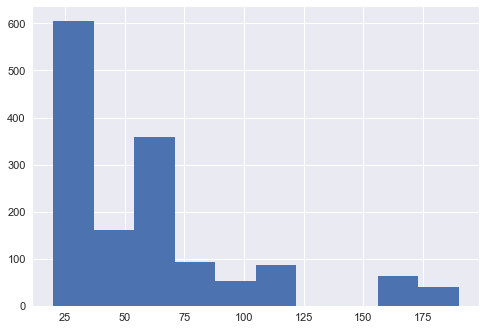

In [239]:
combined_train["MSSubClass"].hist()